In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import os
import random
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Embedding, AveragePooling3D
from sklearn.utils.multiclass import type_of_target
import math
!pip install numpy==1.16.1
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plotTrPr(Y_test, Ypr, name):
    xline = range(0,math.floor(float(max(Y_test))))
    plt.figure()
    plt.plot(Y_test,Ypr,'o')
    plt.grid()
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title('Regression Scatter Plot')
    plt.savefig(str("/content/gdrive/My Drive/SpeedCNN/Plots/Regression_" + name + ".png"))

In [ ]:
X_train = np.load('/content/gdrive/My Drive/SpeedCNN/X_train.npy')
Y_train = np.load('/content/gdrive/My Drive/SpeedCNN/Y_train.npy')
X_train_im = np.asarray([row[3] for row in X_train])
input_shape = X_train_im[0].shape

In [ ]:
import sklearn

def create_network():
    # Create the model
    input_shape = (5, 128, 128, 3)
    model = Sequential()
    model.add(Conv3D(16, kernel_size=(2, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(AveragePooling3D((1,2,2)))
    model.add(BatchNormalization())
    model.add(Conv3D(32, kernel_size=(2, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv3D(64, kernel_size=(2, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=[r2_keras])

    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import linear_model 
from sklearn import metrics
from sklearn.model_selection import cross_validate

# def runCNN(X_train_im, X_test_im, Y_train, Y_test):
    # Calculate input size
def runCNN(X_train_im, Y_train):
    CNN = KerasRegressor(build_fn=create_network, epochs=50, batch_size=10, verbose=1)
    # CNN.fit(X_train_im, Y_train)
    # Ypr = CNN.predict(X_test_im)
    return CNN

CNN = runCNN(X_train_im, Y_train)

In [ ]:
# Fit data to model
history = CNN.fit(X_train_im, Y_train,
            batch_size=20,
            epochs=300,
            verbose=1,
            validation_split=0.3)

In [ ]:
# serialize model to JSON
CNN_json = CNN.model.to_json()
with open("/content/gdrive/My Drive/SpeedCNN/Models/CNN_22_8(5).json", "w") as json_file:
    json_file.write(CNN_json)
# serialize weights to HDF5
CNN.model.save_weights("/content/gdrive/My Drive/SpeedCNN/Models/CNN_22_8(5).h5")
print("Saved model to disk")

In [ ]:
X_test = np.load('/content/gdrive/My Drive/SpeedCNN/X_test.npy')
Y_test = np.load('/content/gdrive/My Drive/SpeedCNN/Y_test.npy')

# Store the image data in its own array
X_test_im = np.asarray([row[3] for row in X_test])
# Calculate input size
print(X_test_im.shape)

(660, 5, 128, 128, 3)


In [ ]:
# Generate generalization metrics
score = CNN.model.evaluate(X_test_im, Y_test, verbose=0)
print('Mean Squared Error: ' + str(score[0]))
print('R2 Score: ' + str(score[1]))

# Plot history: Mean Squared Error
plt.plot(history.history['loss'][1:], label='Mean Squared Error (training data)')
plt.plot(history.history['val_loss'][1:], label='Mean Squared Error (validation data)')
plt.title("Mean Squared Error for Speed Detection")
plt.ylabel('Mean Squared Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# load json and create model
json_file = open('/content/gdrive/My Drive/SpeedCNN/Models/CNN_4_7(2).json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/SpeedCNN/Models/CNN_4_7(2).h5")
print("Loaded model from disk")


Loaded model from disk


In [ ]:
loaded_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_50 (Conv3D)           (None, 4, 126, 126, 16)   880       
_________________________________________________________________
dropout_35 (Dropout)         (None, 4, 126, 126, 16)   0         
_________________________________________________________________
average_pooling3d_22 (Averag (None, 4, 63, 63, 16)     0         
_________________________________________________________________
conv3d_51 (Conv3D)           (None, 3, 61, 61, 32)     9248      
_________________________________________________________________
dropout_36 (Dropout)         (None, 3, 61, 61, 32)     0         
_________________________________________________________________
conv3d_52 (Conv3D)           (None, 2, 59, 59, 64)     36928     
_________________________________________________________________
flatten_21 (Flatten)         (None, 445568)          

In [ ]:
# Generate generalization metrics
loaded_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=[r2_keras])
score = loaded_model.evaluate(X_test_im, Y_test, verbose=0)
print('Mean Squared Error: ' + str(score[0]))
print('R2 Score: ' + str(score[1]))


Mean Squared Error: 166.60813903808594
R2 Score: 0.8622354865074158


Mean Squared Error: 166.60813903808594
R2 Score: 0.8622354865074158


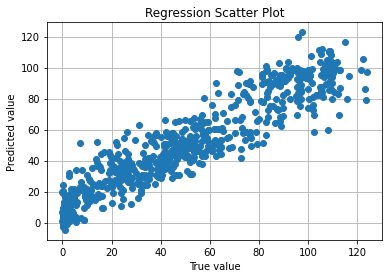

In [ ]:
loaded_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=[r2_keras])
Ypr = loaded_model.predict(X_test_im)
score = loaded_model.evaluate(X_test_im, Y_test, verbose=0)
print('Mean Squared Error: ' + str(score[0]))
print('R2 Score: ' + str(score[1]))
plotTrPr(Y_test, Ypr, "22_8(4)")

**Single Video**


---



---



In [ ]:
X_1V = np.load('/content/gdrive/My Drive/SpeedCNN/X_train_1J.npy')
Y_1V = np.load('/content/gdrive/My Drive/SpeedCNN/Y_train_1J.npy')

# Store the image data in its own array
X_1V_im = np.asarray([row[3] for row in X_1V])
# Calculate input size
print(X_1V_im.shape)

(539, 5, 128, 128, 3)


In [ ]:
# load json and create model
json_file = open('/content/gdrive/My Drive/SpeedCNN/Models/CNN_4_7(2).json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/SpeedCNN/Models/CNN_4_7(2).h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=[r2_keras])
Ypr_1V = loaded_model.predict(X_1V_im)
score = loaded_model.evaluate(X_1V_im, Y_1V, verbose=0)
print('Mean Squared Error: ' + str(score[0]))
print('R2 Score: ' + str(score[1]))
plotTrPr(Y_1V, Ypr_1V, "4_7(2)_1V")
# print(Ypr_1V)

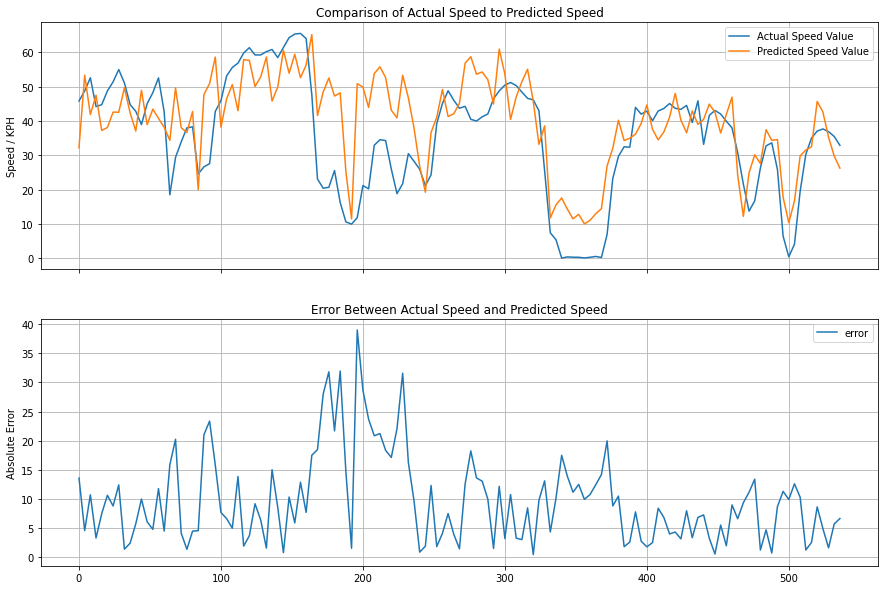

In [ ]:
width2 = 15
height2 = 10
width_height_2 = (width2, height2)

error_no_smooth = []
for i in range(0, len(Ypr_1V)):
  error_no_smooth.extend(abs(Y_1V[i] - Ypr_1V[i]))

inter = 4

f, (ax1, ax2) = plt.subplots(2, 1, sharex='all')
X_smooth = range(0, len(Y_Smooth))
X_1V = range(0, len(Y_1V))
f.set_figheight(height2)
f.set_figwidth(width2)

ax1.plot(X_1V[::inter], Y_1V[::inter], label = 'Actual Speed Value')
ax1.plot(Xpr_1V[::inter], Ypr_1V[::inter], label = 'Predicted Speed Value')
ax1.set_title('Comparison of Actual Speed to Predicted Speed')
ax1.set_ylabel('Speed / KPH')
ax1.legend()
ax1.grid()

ax2.plot(Xpr_1V[::inter], error_no_smooth[::inter], label = 'error')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Error Between Actual Speed and Predicted Speed')
ax2.legend()
ax2.grid()

plt.savefig(str("/content/gdrive/My Drive/SpeedCNN/Plots/ActualvPred.png"))


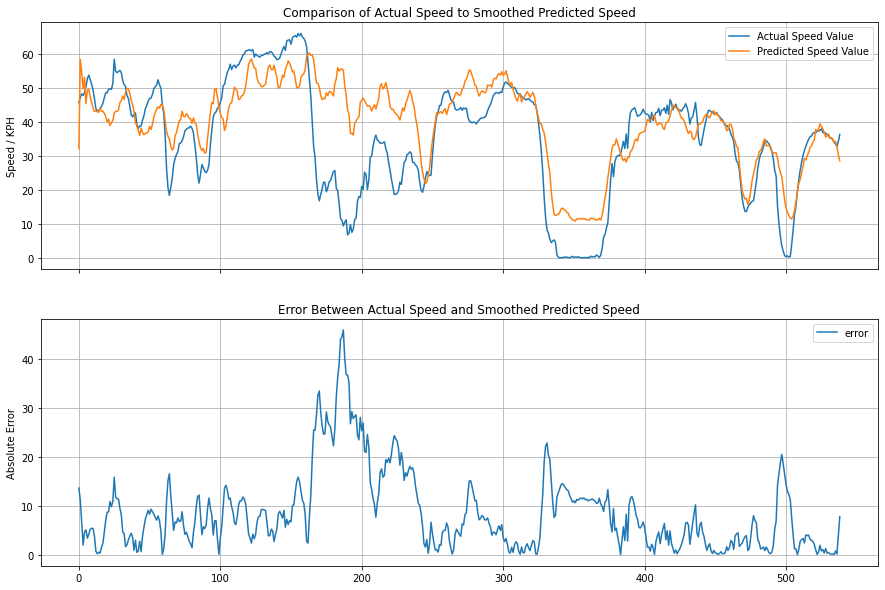

In [ ]:
from statistics import mean
from itertools import chain

n=6
Y_pred_flat = []
for sublist in Ypr_1V:
    for item in sublist:
        Y_pred_flat.append(float(item))
# Y_Smooth = list(chain.from_iterable([mean(Y_pred_flat[i:i+n])]*n for i in range(0,len(Y_pred_flat),n)))
Y_Smooth_most = [mean(Y_pred_flat[i-n:i+1])for i in range(n,len(Y_pred_flat))]
Y_Smooth = Y_pred_flat[0:n]
Y_Smooth.extend(Y_Smooth_most)

error = []
for i in range(0, len(Y_Smooth)):
  error.extend(abs(Y_1V[i] - Y_Smooth[i]))

width2 = 15
height2 = 10
width_height_2 = (width2, height2)

inter = 1


f, (ax1, ax2) = plt.subplots(2, 1, sharex='all')
X_smooth = range(0, len(Y_Smooth))
X_1V = range(0, len(Y_1V))
f.set_figheight(height2)
f.set_figwidth(width2)

ax1.plot(X_1V[::inter], Y_1V[::inter], label = 'Actual Speed Value')
ax1.plot(X_smooth, Y_Smooth, label = 'Predicted Speed Value')
ax1.set_title('Comparison of Actual Speed to Smoothed Predicted Speed')
ax1.set_ylabel('Speed / KPH')
ax1.legend()
ax1.grid()

ax2.plot(X_smooth, error, label = 'error')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Error Between Actual Speed and Smoothed Predicted Speed')
ax2.legend()
ax2.grid()

plt.savefig(str("/content/gdrive/My Drive/SpeedCNN/Plots/ActualvPred_smooth.png"))

**Data Set Analysis**

---



---



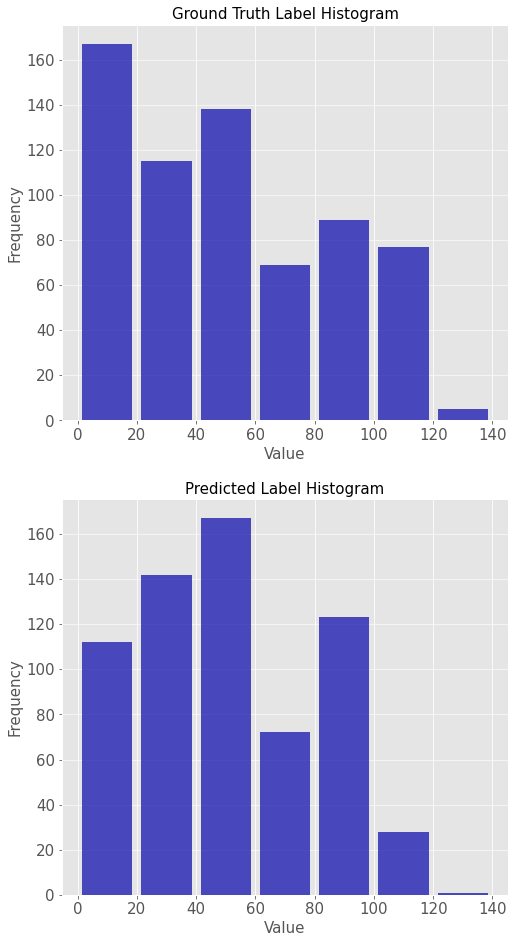

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=[8,16])
plt.subplot(2,1,1)
n, bins, patches = plt.hist(x=Y_test, bins=[0,20,40,60,80,100,120,140], color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Ground Truth Label Histogram',fontsize=15)


plt.subplot(2,1,2)
n, bins, patches = plt.hist(x=Ypr, bins=[0,20,40,60,80,100,120,140], color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Predicted Label Histogram',fontsize=15)


plt.savefig('/content/gdrive/My Drive/SpeedCNN/HistPlotInterimReport.png')


WITH DATA GEN (For Experimentation upon Completing Research)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/content/gdrive/My Drive/SpeedCNN/speed data/fit/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, y
    

class EvalDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/content/gdrive/My Drive/SpeedCNN/speed data/eval/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]
        

        return X, y

In [ ]:
import numpy as np
from keras.models import Sequential
import json
from keras.utils import to_categorical

with open('/content/gdrive/My Drive/SpeedCNN/speed data/labels_fit.json', 'r') as fp:
    labels_fit = json.load(fp)
with open('/content/gdrive/My Drive/SpeedCNN/speed data/partition_fit.json', 'r') as fp:
    partition_fit = json.load(fp)

with open('/content/gdrive/My Drive/SpeedCNN/speed data/labels_eval.json', 'r') as fp:
    labels_eval = json.load(fp)
with open('/content/gdrive/My Drive/SpeedCNN/speed data/partition_eval.json', 'r') as fp:
    partition_eval = json.load(fp)

with open('/content/gdrive/My Drive/SpeedCNN/speed data/IDInfo_fit.json', 'r') as fp:
    IDInfo_fit = json.load(fp)

with open('/content/gdrive/My Drive/SpeedCNN/speed data/IDInfo_eval.json', 'r') as fp:
    IDInfo_eval = json.load(fp)

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display
%matplotlib inline


y_eval = []

x_eval = np.empty((len(labels_eval), 5, 128, 128, 3))
count = 0
for key in labels_eval:
  y_eval.append(labels_eval[key])
  x_eval[count,] = np.load('/content/gdrive/My Drive/SpeedCNN/speed data/eval/' + key + '.npy')
  count += 1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Embedding, AveragePooling3D, ConvLSTM2D
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Parameters
params = {'dim': (5, 128, 128),
      'batch_size': 5,
      'n_classes': 1,
      'n_channels': 3,
      'shuffle': True}

# Generators
training_generator = DataGenerator(partition_fit['train'], labels_fit, **params)
validation_generator = DataGenerator(partition_fit['validation'], labels_fit, **params)
evaluation_generator = EvalDataGenerator(partition_eval['evaluate'], labels_eval, **params)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

date = '26_8'
ver = '01'

# Create the model
input_shape = (5, 128, 128, 3)
model = Sequential()
model.add(Conv3D(16, kernel_size=(2, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Dropout(0.5))
model.add(AveragePooling3D((1,2,2)))
model.add(BatchNormalization())
model.add(Conv3D(32, kernel_size=(2, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv3D(64, kernel_size=(2, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

my_lr = 1e-4

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate = my_lr), metrics=[r2_keras])

model.summary() # check the numbers of parameters at each layers

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(str("/content/gdrive/My Drive/SpeedCNN/Models/" + date +"_(" + ver + ")_best_model.h5"), monitor='val_loss', mode='min', verbose=1, save_best_only = True)

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=6,
                    epochs = 10,
                    callbacks=[es, mc])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 4, 126, 126, 16)   880       
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 126, 126, 16)   0         
_________________________________________________________________
average_pooling3d_2 (Average (None, 4, 63, 63, 16)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 63, 63, 16)     64        
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 3, 61, 61, 32)     9248      
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 61, 61, 32)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 61, 61, 32)    

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(str("/content/gdrive/My Drive/SpeedCNN/Models/" + date +"_(" + ver + ")_best_model.json"), "w") as json_file:
    json_file.write(model_json)

Mean Squared Error: 138.44317626953125
R2 Score: 0.81


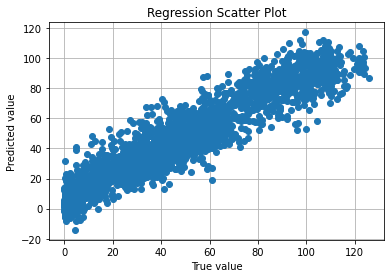

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

mse, r2_long= model.evaluate_generator(generator=evaluation_generator)
r2 = round(r2_long, 2)
print('Mean Squared Error: ' + str(mse))
print('R2 Score: ' + str(r2))

y_pred = model.predict(x_eval)
plotTrPr(y_eval, y_pred, '26_8_(01)')

In [ ]:
ver = '04'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(str("/content/gdrive/My Drive/SpeedCNN/Models/" + date +"_(" + ver + ")_best_model.h5"), monitor='val_loss', mode='min', verbose=1, save_best_only = True)

# Train model on dataset
fourth_training = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=6,
                    epochs = 40,
                    callbacks=[es, mc])

Epoch 1/40
840/840 [==============================] - ETA: 0s - loss: 23.6234 - r2_keras: 0.9610
Epoch 00001: val_loss improved from inf to 122.52575, saving model to /content/gdrive/My Drive/SpeedCNN/Models/26_8_(04)_best_model.h5
840/840 [==============================] - 317s 377ms/step - loss: 23.6234 - r2_keras: 0.9610 - val_loss: 122.5257 - val_r2_keras: 0.8234
Epoch 2/40
840/840 [==============================] - ETA: 0s - loss: 24.5405 - r2_keras: 0.9658
Epoch 00002: val_loss did not improve from 122.52575
840/840 [==============================] - 286s 341ms/step - loss: 24.5405 - r2_keras: 0.9658 - val_loss: 133.7844 - val_r2_keras: 0.7947
Epoch 3/40
840/840 [==============================] - ETA: 0s - loss: 23.4007 - r2_keras: 0.9680
Epoch 00003: val_loss did not improve from 122.52575
840/840 [==============================] - 272s 323ms/step - loss: 23.4007 - r2_keras: 0.9680 - val_loss: 123.1454 - val_r2_keras: 0.8153
Epoch 4/40
840/840 [==============================] - 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(str("/content/gdrive/My Drive/SpeedCNN/Models/" + date +"_(" + ver + ")_best_model.json"), "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize model to JSON
CNN_json = CNN.model.to_json()
with open("/content/gdrive/My Drive/SpeedCNN/Models/CNN_25_8.json", "w") as json_file:
    json_file.write(CNN_json)
# serialize weights to HDF5
CNN.model.save_weights("/content/gdrive/My Drive/SpeedCNN/Models/CNN_25_8.h5")
print("Saved model to disk")

In [ ]:
# Plot history: Mean Squared Error
plt.plot(history.history['loss'][1:], label='Mean Squared Error (training data)')
plt.plot(history.history['val_loss'][1:], label='Mean Squared Error (validation data)')
plt.title("Mean Squared Error for Speed Detection")
plt.ylabel('Mean Squared Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# load json and create model

model = 'CNN_22_8(4)'

json_file = open('/content/gdrive/My Drive/SpeedCNN/Models/' + model + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/content/gdrive/My Drive/SpeedCNN/Models/' + model + '.h5')
print("Loaded model from disk")


In [ ]:
loaded_model.summary()

In [ ]:
# Generate generalization metrics
loaded_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=[r2_keras])
mse, r2_long = loaded_model.evaluate_generator(generator=evaluation_generator)
r2 = round(r2_long, 2)
print('Mean Squared Error: ' + mse)
print('R2 Score: ' + r2)

y_pred = np.argmax(model.predict(x_eval), axis=-1)
plotTrPr(y_eval, y_pred, model)